# Data Modeling

### High Level Approach
- Limiting the number of non fraudulent transactions from the dataset in order to make the extreme class imbalance (1:1000) to an imbalance of lower order.
- Splitting of data into train,test
- Logistic Regression with Grid Search
- RandomForestClassifier with Randomized Search

- Solving for the imbalance in dataset
    - SMOTE
        - Using SMOTE for oversampling of the data
- Testing results using totally unseen data to understand how the model would perform in a production setup

#### Metrics Used:
- Precision
- Recall
- Roc Auc Score
    

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

#import required modules from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix,precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

#import algorithms modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
libdir = os.chdir(r'C:\Users\Nidhi\Desktop\Saransh\FraudDetection')

In [3]:
file = r'./data/interim/preprocessed2.csv'
all_data = pd.read_csv(file)
all_data.head(10)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.0,0.00,0,0,1,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.0,0.00,0,0,1,0,0,0,1,0
2,181.00,181.00,0.00,0.0,0.00,1,0,0,0,0,0,0,1
3,181.00,181.00,0.00,21182.0,0.00,1,0,0,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.0,0.00,0,0,1,0,0,0,1,0
5,7817.71,53860.00,46042.29,0.0,0.00,0,0,1,0,0,0,1,0
6,7107.77,183195.00,176087.23,0.0,0.00,0,0,1,0,0,0,1,0
7,7861.64,176087.23,168225.59,0.0,0.00,0,0,1,0,0,0,1,0
8,4024.36,2671.00,0.00,0.0,0.00,0,0,1,0,0,0,1,0
9,5337.77,41720.00,36382.23,41898.0,40348.79,0,0,0,0,0,1,0,0


In [4]:
_getpercent = int(len(all_data)*.99)
df = all_data.iloc[0:_getpercent]
unseenData = all_data.iloc[_getpercent:]

In [5]:
print('Dataset shape is:',df.shape,df.isFraud.sum())
print('Unseen Dataset shape is:',unseenData.shape,unseenData.isFraud.sum())

Dataset shape is: (6298993, 13) 7501
Unseen Dataset shape is: (63627, 13) 712


In [6]:
# Taking a proportion of nonFraud transactions in order to make dataset less imabalanced

prop = np.random.randint(low=20, high = 40) * df[df.isFraud == 1].isFraud.sum()
nonFraud_df = df[df.isFraud == 0].sample(n=prop)

trimmed_df = pd.concat([nonFraud_df,df[df['isFraud']==1]])
trimmed_df.shape


(247533, 13)

In [52]:
np.random.randint?

In [7]:
#Splitting the dataset into X and y to further feed into the model(s)
X = trimmed_df.drop('isFraud', axis = 1)
y = trimmed_df.isFraud

print('The shape of independent dataset X is:',X.shape)
print('The shape of dependent/predicting dataset y is:',y.shape)

The shape of independent dataset X is: (247533, 12)
The shape of dependent/predicting dataset y is: (247533,)


<font color=blue><b>Due to the highly imbalanced nature of the dataset, it is imperative to handle the imbalanceness otherwise this may cause inaccurate results resulting in models with high accuracy scores but actually not performing well.</font></b>

In [8]:
y.value_counts()

0    240032
1      7501
Name: isFraud, dtype: int64

In [9]:
%pip install imbalanced-learn

In [10]:
#splitting the datasets into train and test in ratio of 25% of test data and 75% for training the model(s)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25, random_state=42)

In [11]:
print('**********Training Data**********')
print(X_train.shape)
print(y_train.value_counts())
print('**********Testing Data**********')
print(X_test.shape)
print(y_test.value_counts())

**********Training Data**********
(185649, 12)
0    179997
1      5652
Name: isFraud, dtype: int64
**********Testing Data**********
(61884, 12)
0    60035
1     1849
Name: isFraud, dtype: int64


In [12]:
X_uD = unseenData.drop('isFraud', axis = 1)
y_uD = unseenData.isFraud
y_uD.value_counts()

0    62915
1      712
Name: isFraud, dtype: int64

In [13]:
def searchCV(searchType,model,hyper_param,X,y):
    clf = searchType(model,hyper_param, cv = 5,scoring = 'roc_auc')
    clf.fit(X,y)
    
    return clf.best_score_, clf.best_params_
"""
def fitBestModel(model,best_params,X,y,X_tst):
    
    m = model(best_params,class_weight=)
    m.fit(X,y)
    
    getConfusionMatrix(y,getPredictionScore(m,X_tst))
    getConfusionMatrixPlot(m,X_tst,y)
"""

def getModelScores(model,X_tst,y_tst):
    
    print('Precision Score for the model:', precision_score(y_tst,model.predict(X_tst)))
    print('Recall score for the model:',recall_score(y_tst,model.predict(X_tst)))
    
    getConfusionMatrix(y_tst,model.predict(X_tst))
    getConfusionMatrixPlot(model,X_tst,y_tst)

def getConfusionMatrix(act,pred):
    
     print(confusion_matrix(act,pred))

def getConfusionMatrixPlot(m,X_tst,y):
    
    print(plot_confusion_matrix(m,X_tst,y))

def plotFprTpr(m,X_tst,y_tst):
    
    yhat = model.predict_proba(X_tst)

    pos_probs = yhat[:, 1]
    # plot no skill roc curve
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
    # calculate roc curve for model
    fpr, tpr, threshold = roc_curve(y_tst, pos_probs)
    # plot model roc curve
    plt.plot(fpr, tpr, marker='.', label=m)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

# Algorithm 1: Logistic Regression

In [14]:
#Defining Hyperparameter for tuning the model and getting best parameter for the model
c = np.logspace(-3,3,10)
param = {'C':c}

In [15]:
model = LogisticRegression(class_weight='balanced')
best_scr, best_params = searchCV(GridSearchCV,model,param,X_train,y_train)


In [16]:
print("Best Score:" + str(best_scr))
print("Best Parameters: " + str(best_params))
best_c = best_params['C']

Best Score:0.9836428581232879
Best Parameters: {'C': 0.001}


In [17]:
model = LogisticRegression(C= best_c,class_weight = 'balanced')
model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced')

Precision Score for the model: 0.19117647058823528
Recall score for the model: 0.9772850189291509
[[52390  7645]
 [   42  1807]]


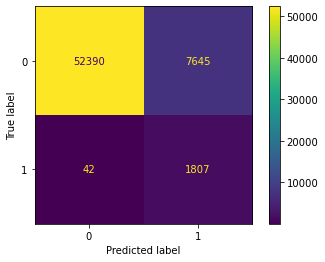

In [18]:
getModelScores(model,X_test,y_test)

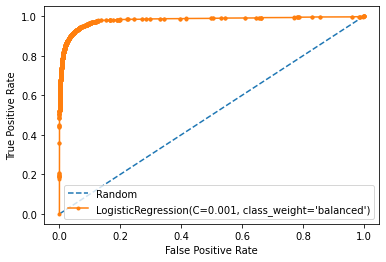

In [19]:
plotFprTpr(model,X_test,y_test)

Precision Score for the model: 0.07112927950945325
Recall score for the model: 0.9775280898876404
[[53826  9089]
 [   16   696]]


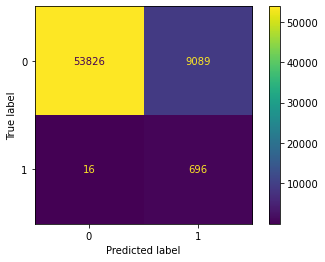

In [20]:
# Testing the model on unseen data
getModelScores(model,X_uD,y_uD)

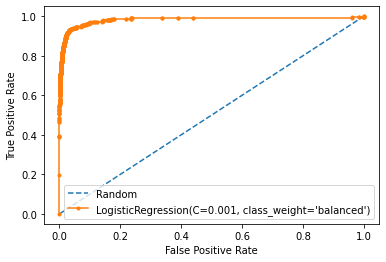

In [21]:
plotFprTpr(model,X_uD,y_uD)

# Algorithm 2: RandomForestClassifier

In [22]:
est = np.linspace(70,120,10).astype('int64')
depth = np.linspace(2,8,4).astype('int64')
param = {'n_estimators':est,'max_depth':depth}

In [23]:
rand = RandomForestClassifier(class_weight='balanced')
best_scr, best_params = searchCV(RandomizedSearchCV,rand,param,X_train,y_train)


In [24]:
print("Best Score:" + str(best_scr))
print("Best Parameters: " + str(best_params))
best_est = best_params['n_estimators']
best_depth = best_params['max_depth']

Best Score:0.996867465536057
Best Parameters: {'n_estimators': 114, 'max_depth': 6}


In [25]:
rand = RandomForestClassifier(n_estimators = best_est,max_depth = best_depth,class_weight='balanced')
rand.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=114)

Precision Score for the model: 0.45855649069115023
Recall score for the model: 0.9724175229853975
[[57912  2123]
 [   51  1798]]


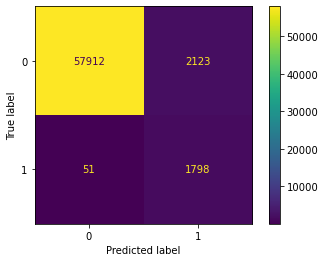

In [26]:
getModelScores(rand, X_test, y_test)

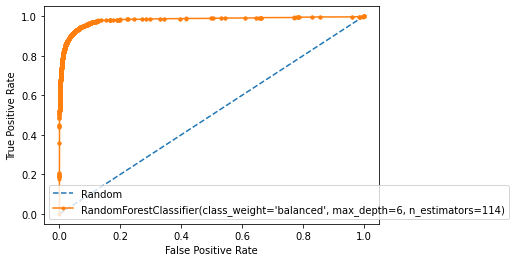

In [27]:
plotFprTpr(rand, X_test, y_test)

Precision Score for the model: 0.21400183430143688
Recall score for the model: 0.9831460674157303
[[60344  2571]
 [   12   700]]


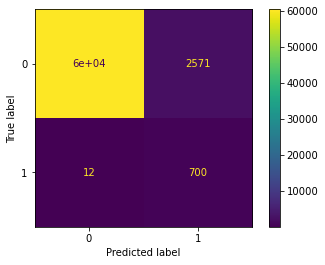

In [28]:
# Testing the model on unseen data
getModelScores(rand, X_uD, y_uD)

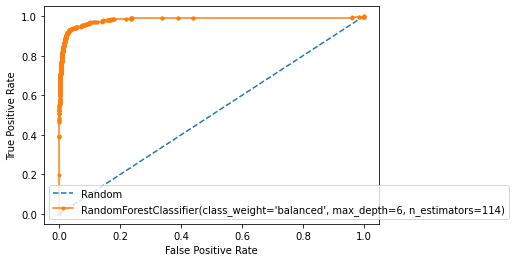

In [29]:
plotFprTpr(rand, X_uD, y_uD)

By limiting the number of non fraudulent transactions we are able to get decent scores for Precision and Recall. However, in a production environment the model would be exptected to all have a loe False Positive Rate and hence a better Precision. 
The following segment deals with methods to solve for the above.

# Applying SMOTE

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
df_smote = trimmed_df
X_smt = df_smote.drop('isFraud', axis = 1)
y_smt = df_smote.isFraud
print(y_smt.value_counts())

0    240032
1      7501
Name: isFraud, dtype: int64


In [32]:
smt = SMOTE()
X_smote, y_smote = smt.fit_resample(X_smt,y_smt)
y_smote.value_counts()

1    240032
0    240032
Name: isFraud, dtype: int64

In [33]:
X_tr_smote,X_test_smote,y_tr_smote,y_test_smote = train_test_split(X_smote, y_smote,test_size=.25)

### Logistic Regression with SMOTE

In [41]:
c = np.logspace(-5,3,10)
param = {'C':c}

model = LogisticRegression(class_weight='balanced')
best_scr, best_params = searchCV(GridSearchCV,model,param,X_tr_smote,y_tr_smote)


logreg = LogisticRegression(C=best_params['C'],class_weight = 'balanced')
logreg.fit(X_tr_smote,y_tr_smote)

LogisticRegression(C=7.742636826811278e-05, class_weight='balanced')

Precision Score for the model: 0.8711854934776534
Recall score for the model: 0.9848215324766005
[[51106  8759]
 [  913 59238]]


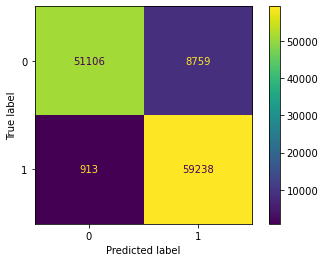

In [42]:
getModelScores(logreg,X_test_smote,y_test_smote)

Precision Score for the model: 0.06431343559416004
Recall score for the model: 0.9775280898876404
[[52789 10126]
 [   16   696]]


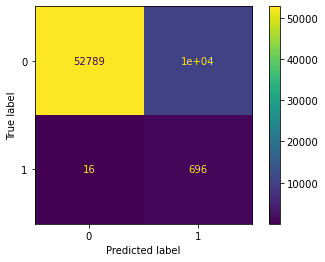

In [45]:
getModelScores(logreg,X_uD,y_uD)

## Random Forest with SMOTE

In [51]:
est = np.linspace(20,150,15).astype('int64')
depth = np.linspace(2,8,4).astype('int64')
param = {'n_estimators':est,'max_depth':depth}

rand = RandomForestClassifier(class_weight='balanced')
best_scr, best_params = searchCV(RandomizedSearchCV,rand,param,X_tr_smote,y_tr_smote)

In [48]:

best_est = best_params['n_estimators']
best_depth = best_params['max_depth']

rand = RandomForestClassifier(n_estimators = best_est,max_depth = best_depth,class_weight='balanced')
rand.fit(X_tr_smote,y_tr_smote)


RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=150)

Precision Score for the model: 0.9718645606979535
Recall score for the model: 0.9963425379461688
[[58130  1735]
 [  220 59931]]


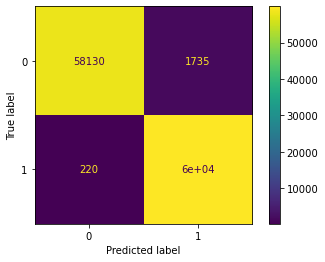

In [49]:
getModelScores(rand,X_test_smote,y_test_smote)

Precision Score for the model: 0.24446749654218533
Recall score for the model: 0.9929775280898876
[[60730  2185]
 [    5   707]]


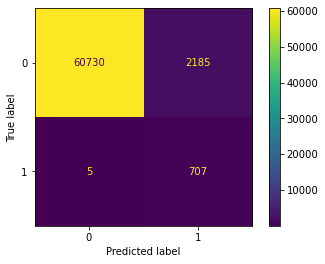

In [50]:
getModelScores(rand,X_uD,y_uD)

# Model Summary
<font color = 'blue'>


### Without handling class imbalance
| Model | Precision | Recall | Precision - Unseen data | Recall - Unseen data |
| --- | --- | --- | --- | --- |
| Logistic Regression | .19 | .977 | .07 | .977 | 
| Random Forest | .45 | .972 | .21 | .983 |

### Applying SMOTE
| Model | Precision | Recall | Precision - Unseen data | Recall - Unseen data |
| --- | --- | --- | --- | --- |
| Logistic Regression | .87 | .985 | .06 | .977 | 
| Random Forest | .97 | .997 | .24 | .993 | 

<b> Random forest after applying SMOTE technique performs best amongst all models
</font>